# Modules

In [1]:
%load_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns

from scipy.stats import wilcoxon, pearsonr, spearmanr

from pdathome.constants import global_constants as gc, mappings as mp
from pdathome.evaluation import bland_altman_plot, calculate_pvalue, plot_significance

# Constants

In [2]:
d_plot_params = {
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,
}

sns.set(rc=d_plot_params)
sns.set_theme(style='white', rc=d_plot_params)

l_segment_cat = ['short', 'moderately_long', 'long', 'very_long']

# Load

In [3]:
d_quant = {}
for subject in gc.participant_ids.L_PD_IDS + gc.participant_ids.L_HC_IDS:
    with open(os.path.join(gc.paths.PATH_OUTPUT, 'quantification', f'{subject}.json'), 'r') as f:
        d_quant[subject] = json.load(f)

# Prepare data

In [4]:
# l_measures = list(d_quant['hbv002']['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'].keys())
l_measures = list(d_quant['hbv002']['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'].keys())

l_dfs = []
for dataset in ['filtered_gait', 'true_no_other_arm_activity']:
    df = pd.DataFrame()
    df['dataset'] = [dataset]*len(gc.participant_ids.L_PD_IDS)*4
    df['population'] = ['Pre-med MAS']*len(gc.participant_ids.L_PD_IDS) + ['Pre-med LAS']*len(gc.participant_ids.L_PD_IDS) + ['Post-med MAS']*len(gc.participant_ids.L_PD_IDS) + ['Post-med LAS']*len(gc.participant_ids.L_PD_IDS)
    df[gc.columns.ID] = gc.participant_ids.L_PD_IDS*4

    for measure in l_measures:
        l_pd_pre_mas = [d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure]['overall'] for x in gc.participant_ids.L_PD_IDS]
        l_pd_pre_las = [d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.LEAST_AFFECTED_SIDE]['values'][measure]['overall'] for x in gc.participant_ids.L_PD_IDS]
        l_pd_post_mas = [d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure]['overall'] for x in gc.participant_ids.L_PD_IDS]
        l_pd_post_las = [d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.LEAST_AFFECTED_SIDE]['values'][measure]['overall'] for x in gc.participant_ids.L_PD_IDS]

        df = pd.concat([df, pd.DataFrame([l_pd_pre_mas + l_pd_pre_las + l_pd_post_mas + l_pd_post_las], index=[measure]).T], axis=1)

    l_dfs.append(df)

df = pd.concat(l_dfs, axis=0)

In [5]:
min_seconds = 60

l_valid_pd_ids = [x for x in gc.participant_ids.L_PD_IDS if d_quant[x]['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall'] >= min_seconds and d_quant[x]['filtered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall'] >= min_seconds]
l_valid_hc_ids = [x for x in gc.participant_ids.L_HC_IDS if d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall'] >= min_seconds]

df_valid = df.loc[df[gc.columns.ID].isin(l_valid_pd_ids)]

# Inspect

In [6]:
print(f"Number of subjects: {len(d_quant.keys())}")
print(f"Number of PD subjects: {len([x for x in gc.participant_ids.L_PD_IDS if x in d_quant.keys()])}")
print(f"Number of HC subjects: {len([x for x in gc.participant_ids.L_HC_IDS if x in d_quant.keys()])}")
print(f"Number of valid PD subjects: {len(l_valid_pd_ids)}")
print(f"Number of valid HC subjects: {len(l_valid_hc_ids)}")

Number of subjects: 45
Number of PD subjects: 22
Number of HC subjects: 23
Number of valid PD subjects: 20
Number of valid HC subjects: 23


#### Amount of data per subject

In [7]:
print("Predicted gait - Minutes of data")

print("\npre-medication")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['unfiltered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} ({np.round(np.std([d_quant[x]['unfiltered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['unfiltered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} - {np.round(np.max([d_quant[x]['unfiltered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)}")

print("\npost-medication")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['unfiltered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} ({np.round(np.std([d_quant[x]['unfiltered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['unfiltered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} - {np.round(np.max([d_quant[x]['unfiltered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)}")

print(f"\ncontrols")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['unfiltered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_hc_ids]),2)} ({np.round(np.std([d_quant[x]['unfiltered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_hc_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['unfiltered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_hc_ids]),2)} - {np.round(np.max([d_quant[x]['unfiltered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_hc_ids]),2)}")

Predicted gait - Minutes of data

pre-medication
Mean (SD): 18.89 (7.98)
Min-Max: 8.27 - 37.83

post-medication
Mean (SD): 17.81 (8.77)
Min-Max: 4.43 - 36.37

controls
Mean (SD): 37.73 (12.23)
Min-Max: 19.5 - 69.82


In [8]:
print("Filtered gait - Minutes of data")

print("\npre-medication")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)}")

print("\npost-medication")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['filtered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['filtered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait'][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_pd_ids]),2)}")

print(f"\ncontrols")
print(f"Mean (SD): {np.round(np.mean([d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_hc_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_hc_ids]),2)})")
print(f"Min-Max: {np.round(np.min([d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_hc_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds']['overall']/60 for x in l_valid_hc_ids]),2)}")

Filtered gait - Minutes of data

pre-medication
Mean (SD): 9.14 (7.18)
Min-Max: 1.23 - 26.82

post-medication
Mean (SD): 9.17 (6.65)
Min-Max: 1.0 - 24.68

controls
Mean (SD): 18.81 (7.71)
Min-Max: 2.68 - 37.15


In [9]:
df_segment_seconds = pd.DataFrame()

for segment_duration in list(mp.segment_rename.keys()) + ['non_gait', 'overall']:
    for med_stage in [gc.descriptives.PRE_MED, gc.descriptives.POST_MED]:
        l_ids = [x for x in l_valid_pd_ids if segment_duration in d_quant[x]['filtered_gait'][med_stage][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'].keys()]
        mean_sd = f"{np.round(np.mean([d_quant[x]['filtered_gait'][med_stage][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'][segment_duration]/60 for x in l_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait'][med_stage][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'][segment_duration]/60 for x in l_ids]),2)})"
        min_max = f"{np.round(np.min([d_quant[x]['filtered_gait'][med_stage][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'][segment_duration]/60 for x in l_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait'][med_stage][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'][segment_duration]/60 for x in l_ids]),2)}"

        df_segment_seconds = pd.concat([df_segment_seconds, pd.DataFrame([segment_duration, med_stage, mean_sd, min_max]).T])

    l_ids = [x for x in l_valid_hc_ids if segment_duration in d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'].keys()]
    mean_sd = f"{np.round(np.mean([d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'][segment_duration]/60 for x in l_ids]),2)} ({np.round(np.std([d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'][segment_duration]/60 for x in l_ids]),2)})"
    min_max = f"{np.round(np.min([d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'][segment_duration]/60 for x in l_ids]),2)} - {np.round(np.max([d_quant[x]['filtered_gait']['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'][segment_duration]/60 for x in l_ids]),2)}"

    df_segment_seconds = pd.concat([df_segment_seconds, pd.DataFrame([segment_duration, 'HC', mean_sd, min_max]).T])  

df_segment_seconds.columns = ['Segment duration', 'Medication stage', 'Mean (SD) number of minutes', 'Min-max number of minutes']
df_segment_seconds.pivot(index='Segment duration', columns='Medication stage', values=['Mean (SD) number of minutes', 'Min-max number of minutes']).reindex(['short', 'moderately_long', 'long', 'very_long', 'non_gait', 'overall'])

Mean (SD) number of minutes                            \
Medication stage                          HC         post          pre   
Segment duration                                                         
short                            0.24 (0.13)  0.06 (0.04)  0.06 (0.06)   
moderately_long                  0.88 (0.41)  0.54 (0.38)  0.39 (0.28)   
long                             1.25 (1.35)  0.62 (0.51)   0.8 (0.41)   
very_long                       14.03 (6.59)  6.94 (6.36)   7.56 (6.9)   
non_gait                         2.47 (1.55)   1.1 (1.03)  0.74 (0.68)   
overall                         18.81 (7.71)  9.17 (6.65)  9.14 (7.18)   

                 Min-max number of minutes                             
Medication stage                        HC         post           pre  
Segment duration                                                       
short                          0.02 - 0.42  0.02 - 0.13   0.02 - 0.22  
moderately_long                0.37 - 2.03   0.03 - 1.5   0.03 - 1.13  
long                           0.07 - 6.52  0.02 - 1.87     0.1 - 1.7  
very_long                      0.27 - 27.7  0.12 - 21.6  0.05 - 24.53  
non_gait                       0.57 - 7.02  0.07 - 5.07   0.13 - 2.57  
overall                       2.68 - 37.15  1.0 - 24.68  1.23 - 26.82

In [10]:
l_counts = [y for z in [list(d_quant[x]['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'].keys()) for x in l_valid_pd_ids] for y in z if y != 'overall']

print("Filtered gait - Number of participants stratified by sequence duration\n")

for seq_dur in mp.segment_map.values():
    print(f"{seq_dur}: {l_counts.count(seq_dur)} / {len(l_valid_pd_ids)}")  

Filtered gait - Number of participants stratified by sequence duration

non_gait: 20 / 20
short: 13 / 20
moderately_long: 20 / 20
long: 20 / 20
very_long: 19 / 20


# Plot data

#### Impact of misclassifications

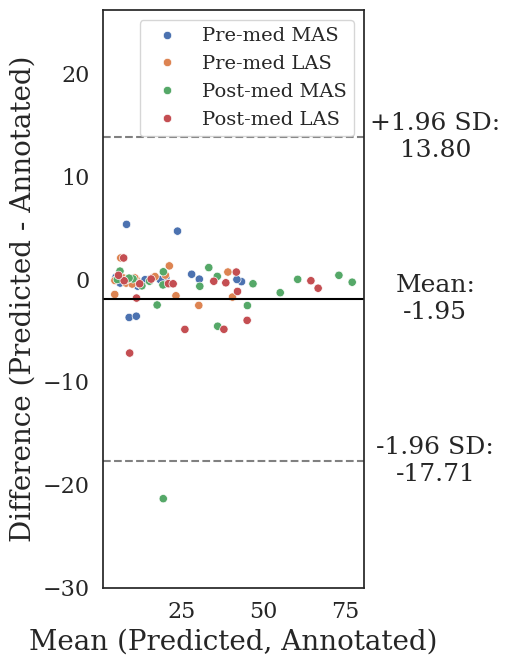

In [66]:
measure = 'range_of_motion_median'

fig, ax = plt.subplots(figsize=(6,7))

ax, colors = bland_altman_plot(df_valid.loc[df_valid['dataset']=='filtered_gait'], df_valid.loc[df_valid['dataset']=='true_no_other_arm_activity'], x=measure, hue='population', axs=ax, legend=True, x_loc_mult_factor=1.35)

ax.legend(loc='upper right')

# ax.set_title(mp.arm_swing_parameter_map[measure])
ax.set_xlabel('Mean (Predicted, Annotated)')
ax.set_ylabel('Difference (Predicted - Annotated)')

fig.tight_layout()

plt.show()

In [71]:
df_valid.loc[(df_valid['dataset']=='filtered_gait') & (df_valid['population'] == 'Pre-med MAS')]

,dataset,population,id,range_of_motion_median,range_of_motion_quantile_95,peak_velocity_median,peak_velocity_quantile_95
0,filtered_gait,Pre-med MAS,hbv002,20.254045,30.203929,70.157028,105.362534
1,filtered_gait,Pre-med MAS,hbv012,18.402734,32.554919,13.194322,53.565683
2,filtered_gait,Pre-med MAS,hbv014,11.226328,20.630404,7.105845,23.351498
3,filtered_gait,Pre-med MAS,hbv015,10.831693,19.975875,46.533929,79.883560
4,filtered_gait,Pre-med MAS,hbv016,5.552672,9.082288,27.305448,44.555401
6,filtered_gait,Pre-med MAS,hbv022,6.098089,14.704681,5.646962,12.478693
7,filtered_gait,Pre-med MAS,hbv024,7.098219,9.969364,5.528720,17.198520
8,filtered_gait,Pre-med MAS,hbv039,5.424261,12.880286,16.331278,36.571424
9,filtered_gait,Pre-med MAS,hbv043,26.074896,50.129731,11.672779,148.139837
10,filtered_gait,Pre-med MAS,hbv047,11.747743,28.649994,7.944706,57.128451


In [72]:
df_valid.loc[(df_valid['dataset']=='true_no_other_arm_activity') & (df_valid['population'] == 'Pre-med MAS')]

,dataset,population,id,range_of_motion_median,range_of_motion_quantile_95,peak_velocity_median,peak_velocity_quantile_95
0,true_no_other_arm_activity,Pre-med MAS,hbv002,20.108960,31.080517,69.801014,109.187252
1,true_no_other_arm_activity,Pre-med MAS,hbv012,18.460579,31.613110,13.911295,55.408933
2,true_no_other_arm_activity,Pre-med MAS,hbv014,11.917933,20.362910,7.461064,25.632637
3,true_no_other_arm_activity,Pre-med MAS,hbv015,5.511748,27.372802,5.255345,103.858555
4,true_no_other_arm_activity,Pre-med MAS,hbv016,5.274991,9.223368,25.743824,44.443837
6,true_no_other_arm_activity,Pre-med MAS,hbv022,6.150254,16.791333,5.714285,17.376308
7,true_no_other_arm_activity,Pre-med MAS,hbv024,10.834973,13.860325,4.697786,11.934965
8,true_no_other_arm_activity,Pre-med MAS,hbv039,5.555690,11.260068,17.255430,34.969306
9,true_no_other_arm_activity,Pre-med MAS,hbv043,21.412697,49.618242,11.962694,145.912266
10,true_no_other_arm_activity,Pre-med MAS,hbv047,12.225707,27.440024,9.263155,60.415674


In [69]:
data1 = np.asarray(df_valid.loc[df_valid['dataset']=='filtered_gait', measure])
data2 = np.asarray(df_valid.loc[df_valid['dataset']=='true_no_other_arm_activity', measure])

np.mean([data1, data2], axis=0)

array([20.1815026 , 18.43165657, 11.57213076,  8.17172041,  5.41383116,
        6.1241717 ,  8.9665956 ,  5.48997541, 23.74379614, 11.98672506,
        6.21661241, 43.29754614, 30.40800141, 11.36113221,  4.93306113,
       11.14683113, 15.05543897, 13.8196721 , 28.06062141, 41.89205355,
        9.40039777, 30.24500619, 16.29022749,  6.39296244,  8.03542837,
        4.56547238, 40.53138192, 11.09249661, 39.13234785, 16.8716667 ,
       21.24504003, 10.2243343 ,  7.21052704, 10.65666764,  4.61732543,
        9.88531654, 20.91787225, 23.26566489, 20.03215998,  8.49736321,
       60.46205699, 33.29690151, 19.40763887, 36.00376858,  5.35266348,
       10.16199819, 19.29374695,  6.16116896, 73.05410244, 30.55477441,
       12.85129631, 46.80074494, 55.12052927, 45.09388682, 17.51658765,
        8.93835065, 15.16852754, 19.38830316, 35.89119392, 77.10942927,
       38.50323223, 20.9941942 ,  7.4297814 , 44.44266156,  5.72138992,
        7.28798585, 45.0127219 ,  9.12466312, 42.07258232, 34.82

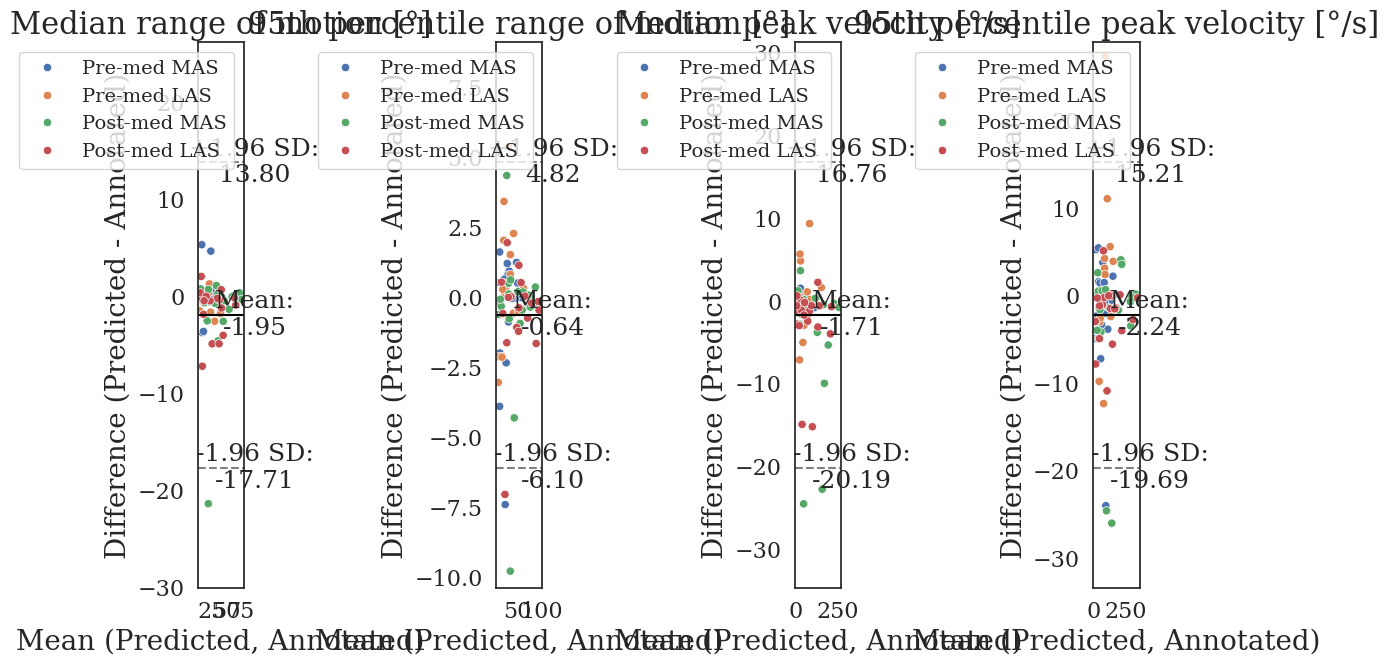

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(12,7))

for j, measure in enumerate(l_measures):
    ax[j], colors = bland_altman_plot(df_valid.loc[df_valid['dataset']=='filtered_gait'], df_valid.loc[df_valid['dataset']=='true_no_other_arm_activity'], x=measure, hue='population', axs=ax[j], legend=True, ax=ax[j], x_loc_mult_factor=1.3)

    ax[j].legend(loc='upper right')

    ax[j].set_title(mp.arm_swing_parameter_map[measure])
    ax[j].set_xlabel('Mean (Predicted, Annotated)')
    ax[j].set_ylabel('Difference (Predicted - Annotated)')

fig.tight_layout()

plt.show()

In [13]:
measure = 'range_of_motion_median'
l_populations = ['PD pre-med MAS', 'PD pre-med LAS', 'PD post-med MAS', 'PD post-med LAS']

l_icc = []
l_pvalue = []
l_ci = []

icc_type = 'ICC1'

for population in df_valid['population'].unique():
    icc = pg.intraclass_corr(data=df_valid.loc[df_valid['population']==population], targets=gc.columns.ID, raters='dataset', ratings=measure)

    l_icc.append(icc.loc[icc['Type']==icc_type, 'ICC'].values[0])
    l_pvalue.append(icc.loc[icc['Type']==icc_type, 'pval'].values[0])
    l_ci.append(icc.loc[icc['Type']==icc_type, 'CI95%'].values[0])

pd.DataFrame([l_populations, l_icc, l_pvalue, l_ci], index=['Population', 'ICC', 'p-value', 'CI95%']).T    

,Population,ICC,p-value,CI95%
0,PD pre-med MAS,0.9857,0.0,"[0.96, 0.99]"
1,PD pre-med LAS,0.995263,0.0,"[0.99, 1.0]"
2,PD post-med MAS,0.974707,0.0,"[0.94, 0.99]"
3,PD post-med LAS,0.709656,0.000118,"[0.41, 0.87]"


#### Sensitivity of arm swing parameters

Population differences

PD pre-med vs PD post-med p-value:  0.000133514404296875
PD post-med vs controls p-value:  0.1968737819074724
PD pre-med vs controls p-value:  0.00013192857102023277


C:\Users\erik_\AppData\Local\Temp\ipykernel_14976\3795805603.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])


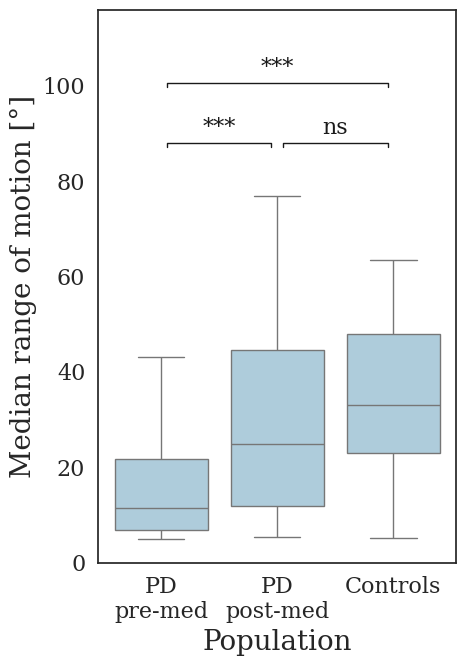

In [14]:
measure = 'range_of_motion_median'
dataset = 'filtered_gait'
segment_duration = 'overall'

l_pd_ids_segments = [x for x in l_valid_pd_ids if segment_duration in d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'].keys() and segment_duration in d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'].keys()]
l_hc_ids_segments = [x for x in l_valid_hc_ids if segment_duration in d_quant[x][dataset]['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['seconds'].keys()]

l_pd_pre_mas = [d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_pd_ids_segments]
l_pd_post_mas = [d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_pd_ids_segments]
l_hc_mas = [d_quant[x][dataset]['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_hc_ids_segments]

df_group = pd.DataFrame([l_pd_pre_mas + l_pd_post_mas + l_hc_mas], index=[measure]).T
df_group['group'] = ['PD pre-med']*len(l_pd_pre_mas) + ['PD post-med']*len(l_pd_post_mas) + ['HC']*len(l_hc_mas)

fig, ax = plt.subplots(figsize=(5,7))

sns.boxplot(x='group', y=measure, data=df_group, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, ax=ax)

ymax = ax.get_ylim()[1]

y_min_significance = ymax * 1.05 
gap = y_min_significance * 1.05 - ymax

p_value = calculate_pvalue(l_pd_pre_mas, l_pd_post_mas, test='wilcoxon')[1]
print("PD pre-med vs PD post-med p-value: ", p_value)

plot_significance(ax=ax, x_min=0.05,
                  x_max=0.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

p_value = calculate_pvalue(l_pd_post_mas, l_hc_mas, test='ranksums')[1]
print("PD post-med vs controls p-value: ", p_value)

plot_significance(ax=ax, x_min=1.05,
                  x_max=1.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 
         
p_value = calculate_pvalue(l_pd_pre_mas, l_hc_mas, test='ranksums')[1]
print("PD pre-med vs controls p-value: ", p_value)

y_min_significance = ymax * 1.2

plot_significance(ax=ax, x_min=0.05,
                  x_max=1.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

ax.set_ylim(0, 1.1*ax.get_ylim()[1])
# ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
ax.set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])

ax.set_ylabel(mp.arm_swing_parameter_map[measure])
ax.set_xlabel('Population')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

PD pre-med MAS vs PD pre-med LAS p-value:  0.7561664581298828
PD post-med MAS vs PD post-med LAS p-value:  0.34881019592285156
Controls MAS vs controls LAS p-value:  0.3294053077697754


C:\Users\erik_\AppData\Local\Temp\ipykernel_14976\3117354420.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['PD pre-med\nMAS', 'PD pre-med\nLAS', 'PD post-med\nMAS',


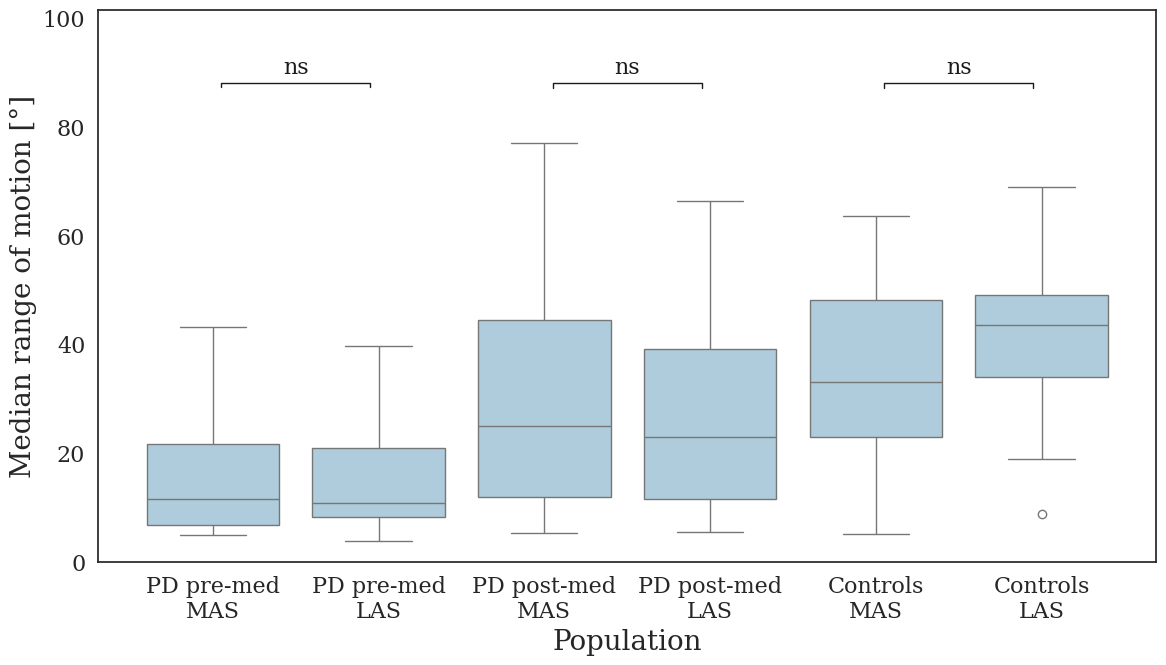

In [15]:
dataset = 'filtered_gait'
measure = 'range_of_motion_median'
sequence_duration = 'overall'

l_pd_pre_mas = [d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_pd_pre_las = [d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.LEAST_AFFECTED_SIDE]['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_pd_post_mas = [d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_pd_post_las = [d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.LEAST_AFFECTED_SIDE]['values'][measure][sequence_duration] for x in l_valid_pd_ids]
l_hc_mas = [d_quant[x][dataset]['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][sequence_duration] for x in l_valid_hc_ids]
l_hc_las = [d_quant[x][dataset]['HC'][gc.descriptives.LEAST_AFFECTED_SIDE]['values'][measure][sequence_duration] for x in l_valid_hc_ids]

df_group = pd.DataFrame([l_pd_pre_mas + l_pd_pre_las + l_pd_post_mas + l_pd_post_las + l_hc_mas + l_hc_las], index=[measure]).T
df_group['group'] = ['PD pre-med MAS']*len(l_pd_pre_mas) + ['PD pre-med LAS']*len(l_pd_pre_las) + ['PD post-med MAS']*len(l_pd_post_mas) + ['PD post-med LAS']*len(l_pd_post_las) + ['HC MAS']*len(l_hc_mas) + ['HC LAS']*len(l_hc_las)

fig, ax = plt.subplots(figsize=(12,7))

sns.boxplot(x='group', y=measure, data=df_group, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, ax=ax)

ymax = ax.get_ylim()[1]

y_min_significance = ymax * 1.05
gap = y_min_significance * 1.05 - ymax

p_value = calculate_pvalue(l_pd_pre_mas, l_pd_pre_las, test='wilcoxon')[1]
print("PD pre-med MAS vs PD pre-med LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=0.05,
                  x_max=0.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

p_value = calculate_pvalue(l_pd_post_mas, l_pd_post_las, test='wilcoxon')[1]
print("PD post-med MAS vs PD post-med LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=2.05,
                  x_max=2.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 
         
p_value = calculate_pvalue(l_hc_mas, l_hc_las, test='wilcoxon')[1]
print("Controls MAS vs controls LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=4.05,
                  x_max=4.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

ax.set_ylim(0, 1.1*ax.get_ylim()[1])
# ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
ax.set_xticklabels(['PD pre-med\nMAS', 'PD pre-med\nLAS', 'PD post-med\nMAS', 
                    'PD post-med\nLAS', 'Controls\nMAS', 'Controls\nLAS'])

# ax.set_ylabel('Peak velocity [deg/s]')
ax.set_ylabel(mp.arm_swing_parameter_map[measure])
ax.set_xlabel('Population')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

C:\Users\erik_\AppData\Local\Temp\ipykernel_14976\168594520.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])
C:\Users\erik_\AppData\Local\Temp\ipykernel_14976\168594520.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])
C:\Users\erik_\AppData\Local\Temp\ipykernel_14976\168594520.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])
C:\Users\erik_\AppData\Local\Temp\ipykernel_14976\168594520.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

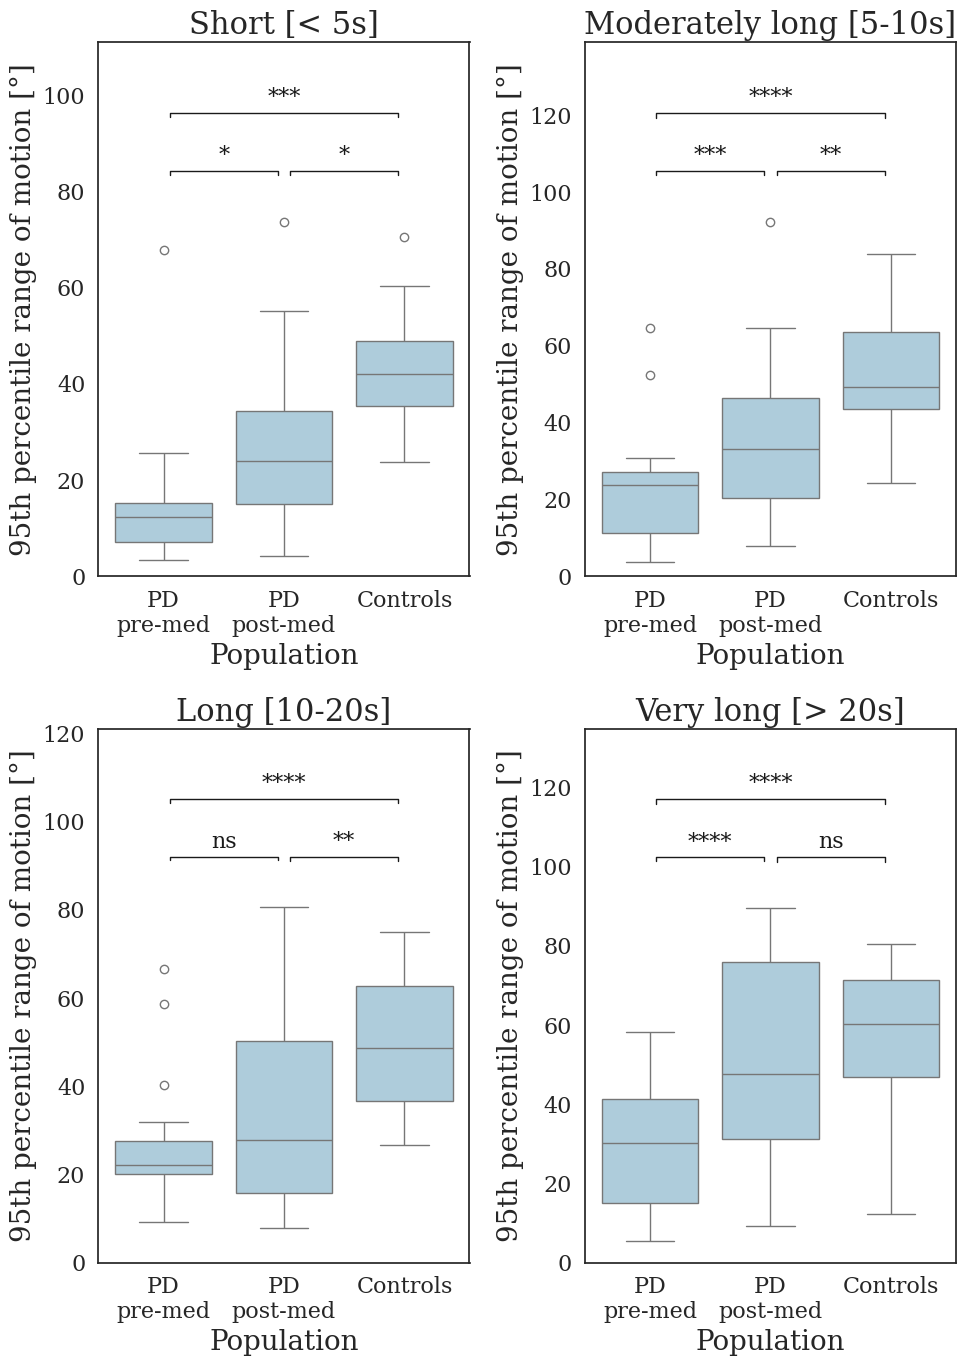

In [16]:
dataset = 'filtered_gait'
measure = 'range_of_motion_quantile_95'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,14))

for i, segment_duration in enumerate(l_segment_cat):

    l_pd_ids_segment = [x for x in l_valid_pd_ids if segment_duration in d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure].keys() and segment_duration in d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure].keys()]
    l_hc_ids_segment = [x for x in l_valid_hc_ids if segment_duration in d_quant[x][dataset]['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure].keys()]

    l_pd_ids_segment_pre = [d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_pd_ids_segment]
    l_pd_ids_segment_post = [d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_pd_ids_segment]
    l_hc_ids_segment = [d_quant[x][dataset]['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_hc_ids_segment]

    df_group = pd.DataFrame([l_pd_ids_segment_pre + l_pd_ids_segment_post + l_hc_ids_segment], index=[measure]).T
    df_group['group'] = ['PD pre-med']*len(l_pd_ids_segment_pre) + ['PD post-med']*len(l_pd_ids_segment_post) + ['HC']*len(l_hc_ids_segment)

    sns.boxplot(x='group', y=measure, data=df_group, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, ax=ax[i//2,i%2])

    ymax = ax[i//2,i%2].get_ylim()[1]

    y_min_significance = ymax * 1.05
    gap = y_min_significance * 1.05 - ymax

    p_value = calculate_pvalue(l_pd_ids_segment_pre, l_pd_ids_segment_post, test='wilcoxon')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=0.05,
                    x_max=0.95, pvalue=p_value,
                    y_min_significance=y_min_significance, gap=gap, row=1, 
                    text_size=16) 
    
    p_value = calculate_pvalue(l_pd_ids_segment_post, l_hc_ids_segment, test='ranksums')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=1.05,
                      x_max=1.95, pvalue=p_value,
                      y_min_significance=y_min_significance, gap=gap, row=1, 
                      text_size=16) 
    
    y_min_significance = ymax * 1.2
    
    p_value = calculate_pvalue(l_pd_ids_segment_pre, l_hc_ids_segment, test='ranksums')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=0.05,
                      x_max=1.95, pvalue=p_value,
                      y_min_significance=y_min_significance, gap=gap, row=1, 
                      text_size=16) 

    ax[i//2,i%2].set_title(f"{mp.segment_rename[segment_duration]}")
    ax[i//2,i%2].set_ylim(0, 1.1*ax[i//2,i%2].get_ylim()[1])
    # ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
    ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])

    ax[i//2,i%2].set_ylabel(mp.arm_swing_parameter_map[measure])
    ax[i//2,i%2].set_xlabel('Population')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

In [17]:
d_filtering_gait_performance = {}
for subject in gc.participant_ids.L_PD_IDS:
    with open(os.path.join(gc.paths.PATH_OUTPUT, 'classification_performance', 'arm_activity', f'{subject}.json'), 'r') as f:
        d_filtering_gait_performance[subject] = json.load(f)

for subject in gc.participant_ids.L_PD_IDS:
    d_quant[subject]['clinical'] = d_filtering_gait_performance[subject]['clinical']

df_filtered = df_valid.loc[df_valid['dataset']=='filtered_gait'].copy()

for subject in gc.participant_ids.L_PD_IDS:
    for med_stage in ['pre', 'post']:
        for affected_side in ['MAS', 'LAS']:
            df_filtered.loc[(df_filtered[gc.columns.ID]==subject) & (df_filtered['population']==f'{med_stage.capitalize()}-med {affected_side}'), 'subscore'] = d_quant[subject]['clinical']['updrs'][med_stage][affected_side]['subscore']
            df_filtered.loc[(df_filtered[gc.columns.ID]==subject) & (df_filtered['population']==f'{med_stage.capitalize()}-med {affected_side}'), 'total_score'] = d_quant[subject]['clinical']['updrs'][med_stage][affected_side]['total']


In [18]:
df_filtered.head()

,dataset,population,id,range_of_motion_median,range_of_motion_quantile_95,peak_velocity_median,peak_velocity_quantile_95,subscore,total_score
0,filtered_gait,Pre-med MAS,hbv002,20.254045,30.203929,70.157028,105.362534,8.0,11.0
1,filtered_gait,Pre-med MAS,hbv012,18.402734,32.554919,13.194322,53.565683,10.0,18.0
2,filtered_gait,Pre-med MAS,hbv014,11.226328,20.630404,7.105845,23.351498,12.0,14.0
3,filtered_gait,Pre-med MAS,hbv015,10.831693,19.975875,46.533929,79.883560,17.0,24.0
4,filtered_gait,Pre-med MAS,hbv016,5.552672,9.082288,27.305448,44.555401,8.0,10.0


95th percentile range of motion [°]
Correlation: -0.3962 [-0.71361077  0.05617736]
P-value: 0.0837


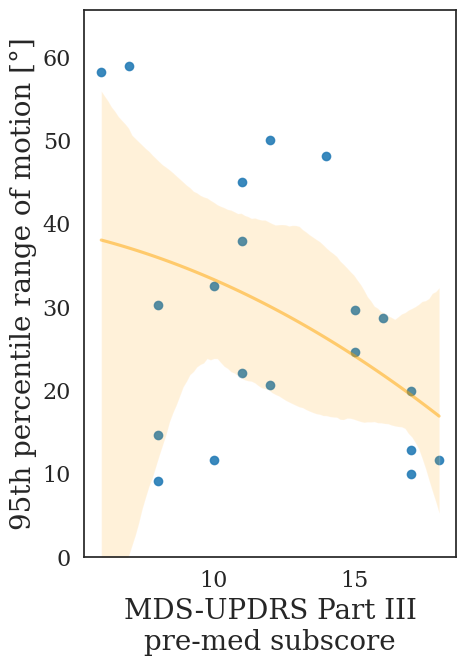

In [74]:
measure = 'range_of_motion_quantile_95'
correlation_metric = 'spearman'

df_med = df_filtered.loc[df_filtered['population']=='Pre-med MAS']

fig, ax = plt.subplots(figsize=(5,7))

sns.scatterplot(data=df_med, x='subscore', y=measure, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)
sns.regplot(x='subscore', y=measure, data=df_med, order=2,
            scatter_kws={'color': gc.plot_parameters.COLOR_PALETTE_SECOND_COLOR}, ci=95,
            line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PD patient', ax=ax)

if correlation_metric == 'pearson':
    rho = np.round(pearsonr(df_med[measure], df_med['subscore']).statistic,4)
    p_value = np.round(pearsonr(df_med[measure], df_med['subscore']).pvalue,4)
else:
    rho = np.round(spearmanr(df_med[measure], df_med['subscore']).correlation,4)
    p_value = np.round(spearmanr(df_med[measure], df_med['subscore']).pvalue,4)

zr = np.log((1+rho)/(1-rho))/2
lower = zr - 1.96/np.sqrt(len(df_med)-3)
upper = zr + 1.96/np.sqrt(len(df_med)-3)

ci = np.tanh(np.array([lower, upper]))

# print(np.round(rho,2), ci, p_value)

print(f"{mp.arm_swing_parameter_map[measure]}\nCorrelation: {rho} {ci}\nP-value: {p_value}")

# ax.set_title(f"{mp.arm_swing_parameter_map[measure]}\nCorrelation: {rho}\nP-value: {p_value}")

ax.set_ylabel(mp.arm_swing_parameter_map[measure])
# ax.set_xlabel(d_clinical_rename['OFF_UPDRS_3_hypokinesia'])
ax.set_xlabel('MDS-UPDRS Part III\npre-med subscore')

ax.set_ylim([0, 1.05*ax.get_ylim()[1]])

fig.tight_layout()

plt.show()

#### Added value of filtering gait

Segment duration: overall
N subjects: 20/20
P-value: 0.012079238891601562


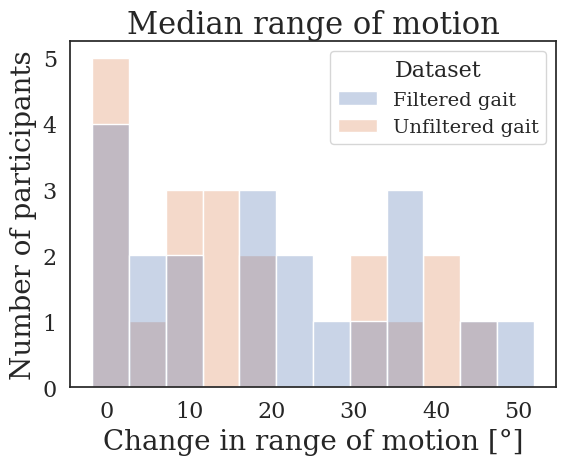

In [79]:
measure = '95p_rom'
segment_duration = 'overall'
dataset_1 = 'pred_gait_predicted_noaa'
dataset_2 = 'predicted_gait'
std_corrected = False

# l_ids_little_data = ['hbv0013', 'hbv018', 'hbv054', 'hbv039', 'hbv017']

l_valid_ids = [x for x in l_valid_pd_ids if segment_duration in d_quant[x]['effect_size'][measure][dataset_1].keys() and segment_duration in d_quant[x]['effect_size'][measure][dataset_2].keys()] 
# l_valid_ids = [x for x in l_valid_ids if x not in l_ids_little_data]

print(f"Segment duration: {segment_duration}\nN subjects: {len(l_valid_ids)}/{len(l_valid_pd_ids)}")
if std_corrected:
    l_vals_filtered = [d_quant[x]['effect_size'][measure][dataset_1][segment_duration]['effect_size'] for x in l_valid_ids]
    l_vals_unfiltered = [d_quant[x]['effect_size'][measure][dataset_2][segment_duration]['effect_size'] for x in l_valid_ids]
else:
    l_vals_filtered = [d_quant[x]['effect_size'][measure][dataset_1][segment_duration]['mu_post'] - d_quant[x]['effect_size'][measure][dataset_1][segment_duration]['mu_pre'] for x in l_valid_ids]
    l_vals_unfiltered = [d_quant[x]['effect_size'][measure][dataset_2][segment_duration]['mu_post'] - d_quant[x]['effect_size'][measure][dataset_2][segment_duration]['mu_pre'] for x in l_valid_ids]

fig, ax = plt.subplots(figsize=(6,5))

df_filtered_gait = pd.DataFrame(l_vals_filtered, columns=['effect_size'])
df_unfiltered_gait = pd.DataFrame(l_vals_unfiltered, columns=['effect_size'])

df_filtered_gait['Dataset'] = 'Filtered gait'
df_unfiltered_gait['Dataset'] = 'Unfiltered gait'

df_all = pd.concat([df_filtered_gait, df_unfiltered_gait], ignore_index=True).reset_index(drop=True)
df_all['id'] = l_valid_ids * 2

print(f"P-value: {wilcoxon(l_vals_filtered, l_vals_unfiltered, alternative='two-sided')[1]}")

g = sns.histplot(data=df_all, x='effect_size', hue='Dataset', alpha=0.3, fill=True, bins=12, common_norm=False, legend=False)

ax.set_xlabel(f'Change in range of motion [°]')
ax.set_ylabel('Number of participants')
ax.set_title('Median range of motion')
ax.yaxis.get_major_locator().set_params(integer=True)
ax.legend(title='Dataset', labels=['Unfiltered gait', 'Filtered gait'], reverse=True, loc='upper right')

fig.tight_layout()

plt.show()

In [21]:
measure = '95p_rom'

for dataset in [dataset_1, dataset_2]:
    print(dataset)
    print("MEAN")
    l_mean = [d_quant[x]['effect_size'][measure][dataset]['overall']['mu_post'] - d_quant[x]['effect_size'][measure][dataset]['overall']['mu_pre'] for x in l_valid_pd_ids]
    print(f"{np.round(np.mean(l_mean),2)} ({np.round(np.std(l_mean),2)})")

    print("STD")
    l_std = [d_quant[x]['effect_size'][measure][dataset]['overall']['std'] for x in l_valid_pd_ids]
    print(f"{np.round(np.mean(l_std),2)} ({np.round(np.std(l_std),2)})")

    print("SRM")
    l_srm = [d_quant[x]['effect_size'][measure][dataset]['overall']['effect_size'] for x in l_valid_pd_ids]
    print(f"{np.round(np.mean(l_srm),2)} ({np.round(np.std(l_srm),2)})\n")

pred_gait_predicted_noaa
MEAN
19.91 (15.7)
STD
1.92 (1.32)
SRM
13.94 (14.88)

predicted_gait
MEAN
17.1 (14.87)
STD
1.46 (0.76)
SRM
14.56 (14.91)



In [64]:
measure = '95p_rom'
df_time_std = pd.DataFrame()

for subject in gc.participant_ids.L_PD_IDS:
    mins_gait = np.round((d_quant[subject]['unfiltered_gait']['pre']['MAS']['seconds']['overall'] + d_quant[subject]['unfiltered_gait']['post']['MAS']['seconds']['overall']) / 60, 1)
    std_gait = np.round(d_quant[subject]['effect_size'][measure]['predicted_gait']['overall']['std'], 2)
    mins_arm_swing = np.round((d_quant[subject]['filtered_gait']['pre']['MAS']['seconds']['overall'] + d_quant[subject]['filtered_gait']['post']['MAS']['seconds']['overall']) / 60, 1)
    std_arm_swing = np.round(d_quant[subject]['effect_size'][measure]['pred_gait_predicted_noaa']['overall']['std'], 2)

    perc_increase_time = (mins_arm_swing-mins_gait)/mins_gait*100
    perc_increase_std = (std_arm_swing-std_gait)/std_gait*100

    df_time_std = pd.concat([df_time_std, pd.DataFrame([mins_gait, std_gait, mins_arm_swing, std_arm_swing, perc_increase_time, perc_increase_std], index=['mins_gait', 'std_gait', 'mins_arm_swing', 'std_arm_swing', '%_change_time', '%_change_std'], columns=[subject]).T])

df_time_std

,mins_gait,std_gait,mins_arm_swing,std_arm_swing,%_change_time,%_change_std
hbv002,31.2,0.80,22.1,0.81,-29.166667,1.250000
hbv012,28.1,3.37,7.4,2.57,-73.665480,-23.738872
hbv014,37.6,0.90,19.7,1.02,-47.606383,13.333333
hbv015,32.3,2.57,6.8,4.59,-78.947368,78.599222
hbv016,17.8,1.33,6.5,0.50,-63.483146,-62.406015
hbv017,28.2,0.84,2.3,1.86,-91.843972,121.428571
hbv022,37.9,1.10,26.7,0.85,-29.551451,-22.727273
hbv024,34.5,0.86,14.1,0.78,-59.130435,-9.302326
hbv039,48.1,0.24,2.9,2.18,-93.970894,808.333333
hbv043,24.0,0.86,12.1,1.23,-49.583333,43.023256


<Axes: xlabel='%_change_time', ylabel='%_change_std'>

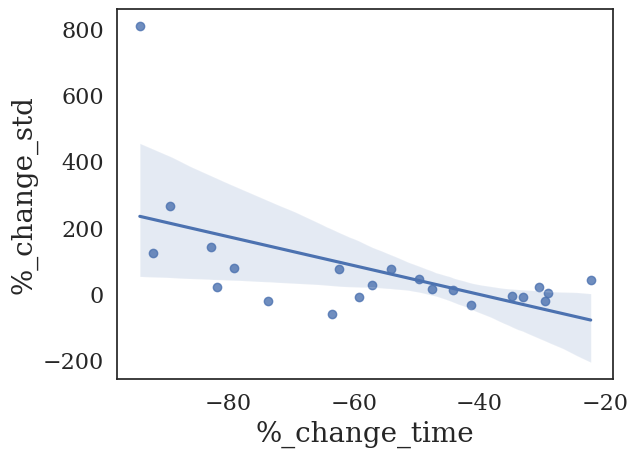

In [65]:
sns.regplot(data=df_time_std, x='%_change_time', y='%_change_std')

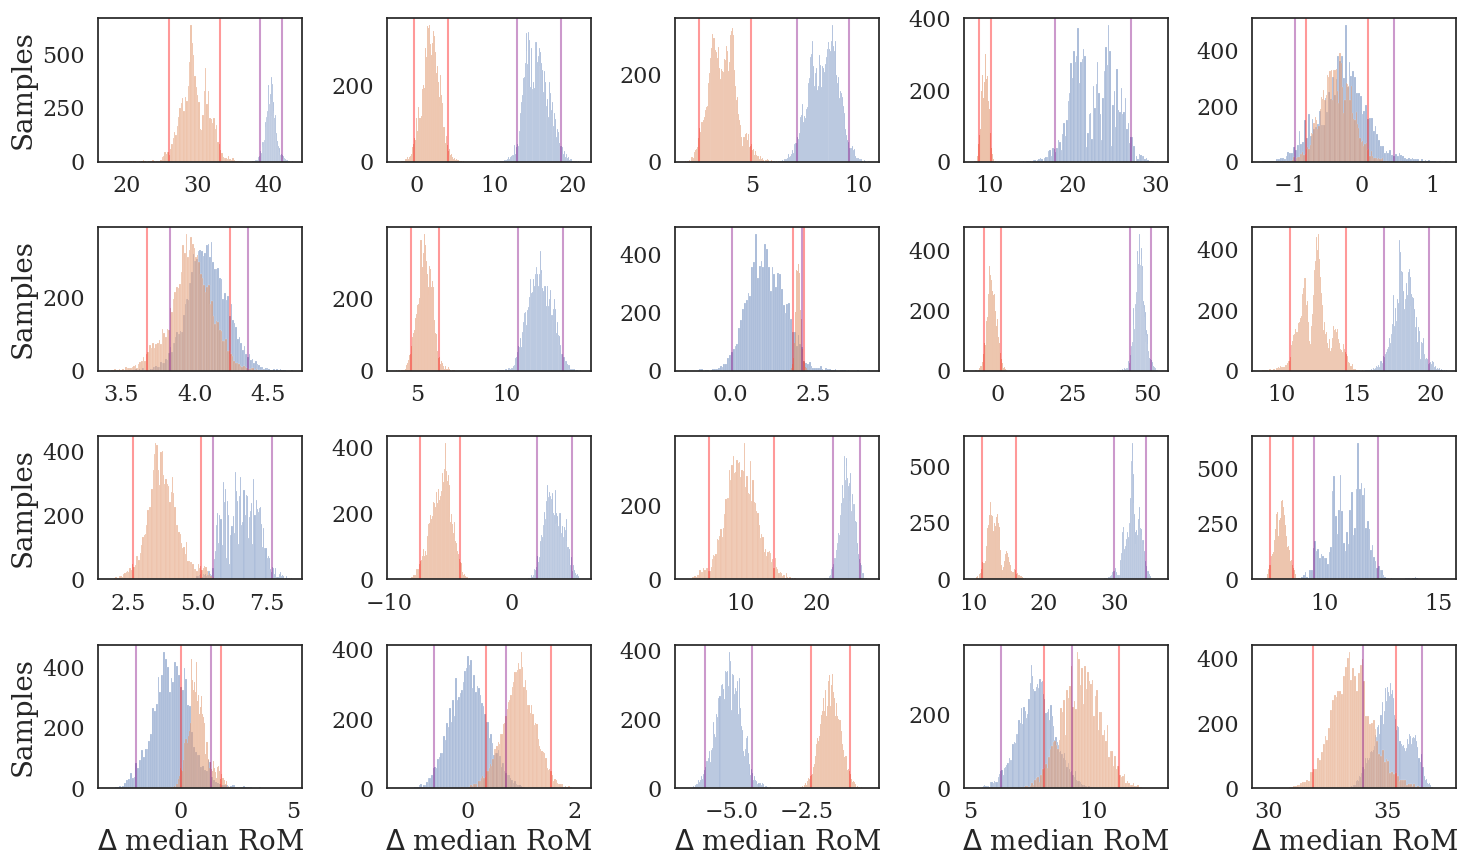

In [24]:
ncols = 5
parameter = 'median_rom'

fig, ax = plt.subplots(nrows=len(l_valid_pd_ids)//ncols, ncols=ncols, figsize=(15, 9))

for j, subject in enumerate(l_valid_pd_ids):
    df_es = pd.read_pickle(os.path.join(gc.paths.PATH_OUTPUT, 'quantification', f'{subject}.pkl'))
    df_es.loc[df_es['dataset']=='predicted_gait', 'dataset'] = 'Unfiltered gait'
    df_es.loc[df_es['dataset']=='pred_gait_predicted_noaa', 'dataset'] = 'Filtered gait'

    for dataset in ['Filtered gait', 'Unfiltered gait']:
        sns.histplot(data=df_es.loc[df_es['dataset']==dataset, f'diff_{parameter}'].values[0], bins=100, ax=ax[j//ncols, j%ncols], alpha=0.5, kde=False)

    # ax[j//ncols, j%ncols].legend(title='Dataset', loc='upper left')

    for qnt in [0.025, 0.975]:
        ax[j//ncols, j%ncols].axvline(x=np.quantile(sorted(df_es.loc[df_es['dataset']=='Filtered gait', f'diff_{parameter}'].values), qnt), alpha=0.4, color='purple')
        ax[j//ncols, j%ncols].axvline(x=np.quantile(sorted(df_es.loc[df_es['dataset']=='Unfiltered gait', f'diff_{parameter}'].values), qnt), alpha=0.4, color='red')

    # ax[j//ncols, j%ncols].set_title(subject)
    # if l_valid_pd_ids.index(subject) % nrows == 0:
    #     ax[j//ncols, j%ncols].set_ylabel('Samples')
    # else:
    #     ax[j//ncols, j%ncols].set_ylabel('')

    if j//ncols == 3:
        ax[j//ncols, j%ncols].set_xlabel(r'$\Delta$ median RoM')  
    else:
        ax[j//ncols, j%ncols].set_xlabel('')
    
    if j%ncols == 0:
        ax[j//ncols, j%ncols].set_ylabel('Samples')
    else:
        ax[j//ncols, j%ncols].set_ylabel('')

fig.tight_layout()

plt.show()    

### Exploration effect size
1. How does the ROM change after medication intake, for filtered and unfiltered gait, based on video annotations?
    - Effect size filtered vs unfiltered gait
    - Absolute change in arm swing parameters 
    - Change in ROM distribution

2. And based on the filter?

#### 1a - Effect size filtered vs unfiltered gait


Measure: median_rom
P-value overall segments: 0.026641845703125
P-value short segments: 0.4130859375
P-value moderately_long segments: 0.3954620361328125
P-value long segments: 0.02684783935546875
P-value very_long segments: 0.18186569213867188

Measure: 95p_rom
P-value overall segments: 0.5458755493164062
P-value short segments: 0.7646484375
P-value moderately_long segments: 0.4413337707519531
P-value long segments: 0.550872802734375
P-value very_long segments: 0.9843215942382812


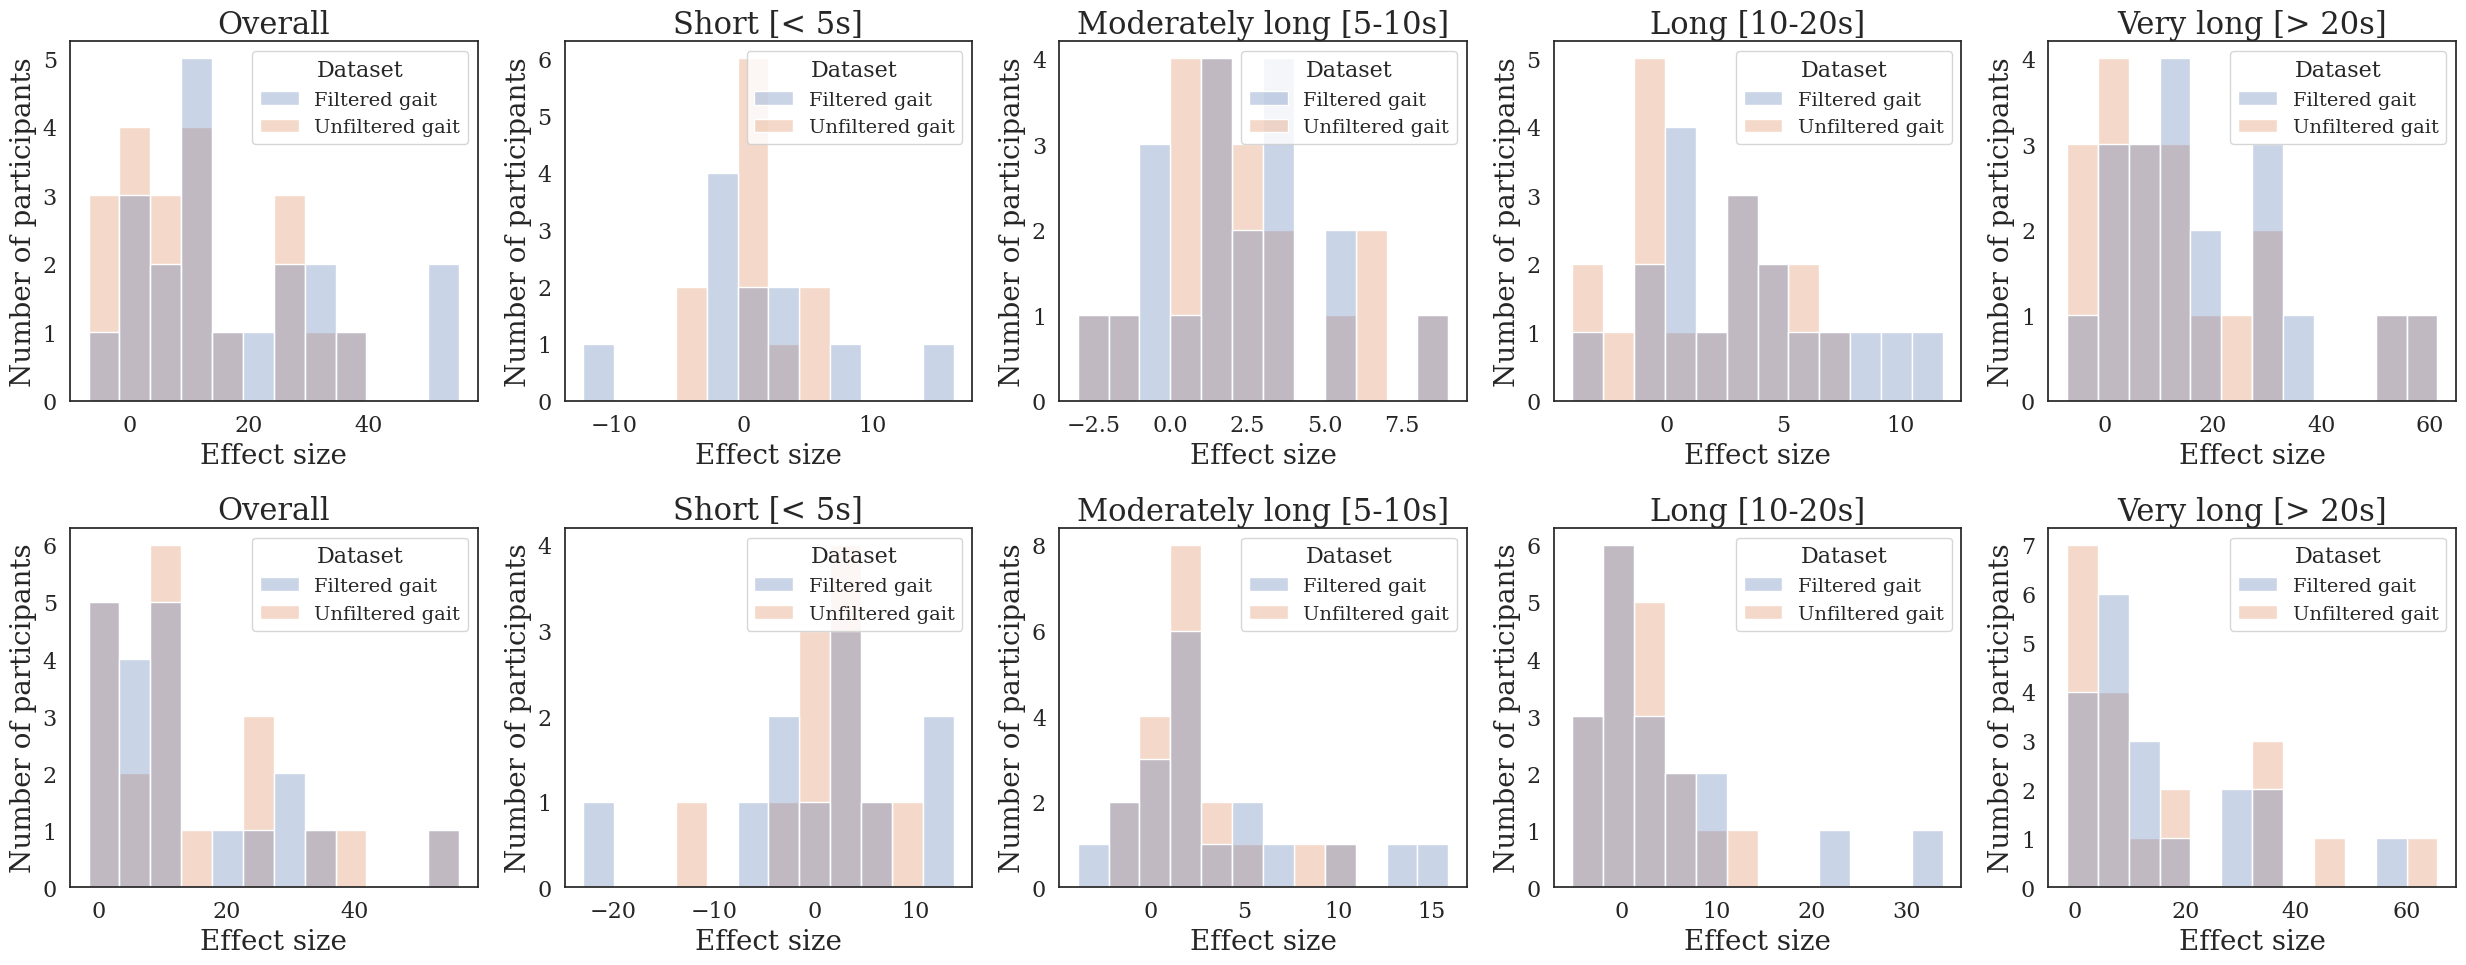

In [25]:
dataset_1 = 'pred_gait_annotated_noaa'
dataset_2 = 'predicted_gait'

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))

for i, measure in enumerate(['median_rom', '95p_rom']):
    print(f"\nMeasure: {measure}")
    for j, segment_duration in enumerate(['overall', 'short', 'moderately_long', 'long', 'very_long']):
        l_valid_ids = [x for x in l_valid_pd_ids if segment_duration in d_quant[x]['effect_size'][measure][dataset_1].keys() and segment_duration in d_quant[x]['effect_size'][measure][dataset_2].keys()] 

        l_vals_filtered = [d_quant[x]['effect_size'][measure][dataset_1][segment_duration]['effect_size'] for x in l_valid_ids]
        l_vals_unfiltered = [d_quant[x]['effect_size'][measure][dataset_2][segment_duration]['effect_size'] for x in l_valid_ids]

        df_filtered_gait = pd.DataFrame(l_vals_filtered, columns=['effect_size'])
        df_unfiltered_gait = pd.DataFrame(l_vals_unfiltered, columns=['effect_size'])

        df_filtered_gait['Dataset'] = 'Filtered gait'
        df_unfiltered_gait['Dataset'] = 'Unfiltered gait'

        df_all = pd.concat([df_filtered_gait, df_unfiltered_gait], ignore_index=True).reset_index(drop=True)

        print(f"P-value {segment_duration} segments: {wilcoxon(l_vals_filtered, l_vals_unfiltered, alternative='two-sided')[1]}")

        g = sns.histplot(data=df_all, x='effect_size', hue='Dataset', alpha=0.3, fill=True, bins=12, common_norm=False, legend=False, ax=ax[i,j])

        if segment_duration != 'overall': 
            ax[i,j].set_title(f"{mp.segment_rename[segment_duration]}")
        else:
            ax[i,j].set_title(f"Overall")
        ax[i,j].set_xlabel('Effect size')
        ax[i,j].set_ylabel('Number of participants')
        ax[i,j].yaxis.get_major_locator().set_params(integer=True)
        ax[i,j].legend(title='Dataset', labels=['Unfiltered gait', 'Filtered gait'], reverse=True, loc='upper right')

fig.tight_layout()

plt.show()

#### 1b - Absolute change in arm swing parameters

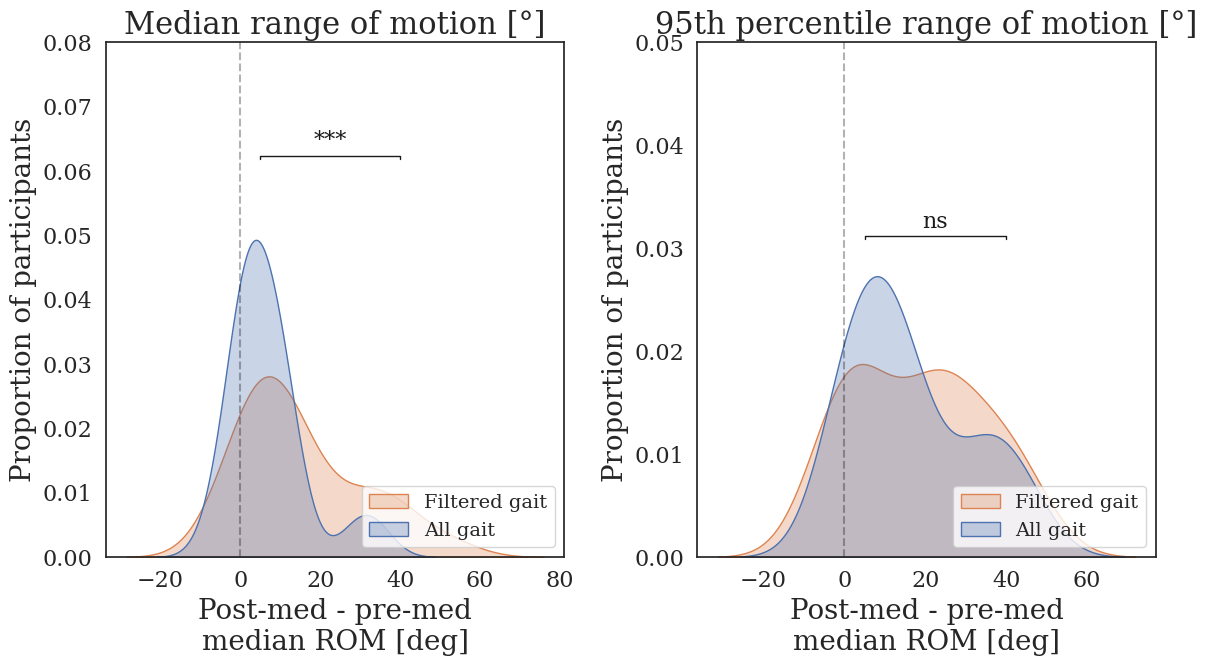

In [41]:
df_abs_change = pd.DataFrame()
for subject in gc.participant_ids.L_PD_IDS:
    for dataset in ['unfiltered_gait', 'true_no_other_arm_activity']:
        for affected_side in [gc.descriptives.MOST_AFFECTED_SIDE, gc.descriptives.LEAST_AFFECTED_SIDE]:
            for measure in ['range_of_motion_median', 'range_of_motion_quantile_95']:
                if measure in d_quant[subject][dataset]['pre'][affected_side]['values'].keys():
                    abs_change = d_quant[subject][dataset]['post'][affected_side]['values'][measure]['overall'] - d_quant[subject][dataset]['pre'][affected_side]['values'][measure]['overall']
                    df_abs_change = pd.concat([df_abs_change, pd.DataFrame([subject, dataset, affected_side, measure, abs_change], index=['id', 'dataset', 'side', 'measure', 'abs_change']).T])

fig, ax = plt.subplots(ncols=2, figsize=(12,7))

for j, measure in enumerate(['range_of_motion_median', 'range_of_motion_quantile_95']):

    df_measure = df_abs_change.loc[(df_abs_change['measure']==measure) & (df_abs_change['side']=='MAS')]

    sns.kdeplot(data=df_measure, x='abs_change', hue='dataset', alpha=0.3, fill=True, common_norm=False, ax=ax[j])

    # ax.set_xlim([df_abs_change[f'{metric}_diff'].min(), df_abs_change[f'{metric}_diff'].max()])

    p_value = calculate_pvalue(x=list(df_measure.loc[df_measure['dataset']=='unfiltered_gait', 'abs_change'].values), 
                               y=list(df_measure.loc[df_measure['dataset']=='true_no_other_arm_activity', 'abs_change'].values),
                               test='wilcoxon')[1]

    x_min = 5
    x_max = 40
    if j == 0:
        y_min_significance = 0.06
        y_max = 0.08
    else:
        y_min_significance = 0.03
        y_max = 0.05

    plot_significance(ax=ax[j], x_min=x_min, x_max=x_max, pvalue=p_value, y_min_significance=y_min_significance, gap=0, row=1, text_size=16)
    ax[j].set_ylim([0, y_max])
    ax[j].axvline(0, color='black', linestyle='--', alpha=0.3)

    # xlabel =  'Post-med - pre-med\n' + r'$95^{th}$ perc ROM [deg]'
    xlabel = 'Post-med - pre-med\nmedian ROM [deg]'

    ax[j].set_title(mp.arm_swing_parameter_map[measure])
    ax[j].legend(['Filtered gait', 'All gait'], loc='lower right')
    ax[j].set_xlabel(xlabel)
    ax[j].set_ylabel('Proportion of participants')
# plt.ylim([0, 0.18])
# plt.title("Difference in median range of motion between PD OFF and PD ON")

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_diff_density_med.png'))

plt.show()

In [27]:
# Standard deviation
df_std = pd.DataFrame()
for subject in gc.participant_ids.L_PD_IDS:
    for dataset in ['predicted_gait', 'pred_gait_annotated_noaa', 'pred_gait_predicted_noaa']:
        for measure in ['median_rom', '95p_rom']:
            for stat in ['mu_pre', 'mu_post', 'std', 'effect_size']:
                df_std = pd.concat([df_std, pd.DataFrame([subject, dataset, measure, stat, d_quant[subject]['effect_size'][measure][dataset]['overall'][stat]], index=['id', 'dataset', 'measure', 'stat', 'value']).T])
            
df_std.pivot_table(index='dataset', columns=['measure', 'stat'], values='value').reindex(['median_rom', '95p_rom'], axis=1, level=0).sort_index(level=0, ascending=False)

measure                   median_rom                                  \
stat                     effect_size    mu_post     mu_pre       std   
dataset                                                                
predicted_gait             11.194371  20.388634  13.564605  0.729861   
pred_gait_predicted_noaa   15.168002  29.627981  16.092715  0.987817   
pred_gait_annotated_noaa   17.577443  31.080913  15.853796  1.038464   

measure                      95p_rom                                  
stat                     effect_size    mu_post     mu_pre       std  
dataset                                                               
predicted_gait              13.77081  45.629559  29.358658  1.534175  
pred_gait_predicted_noaa   12.806175  47.651235   29.27275   2.46026  
pred_gait_annotated_noaa   12.511019  47.762885  29.577775  2.397975

#### 1c - Change in ROM distribution

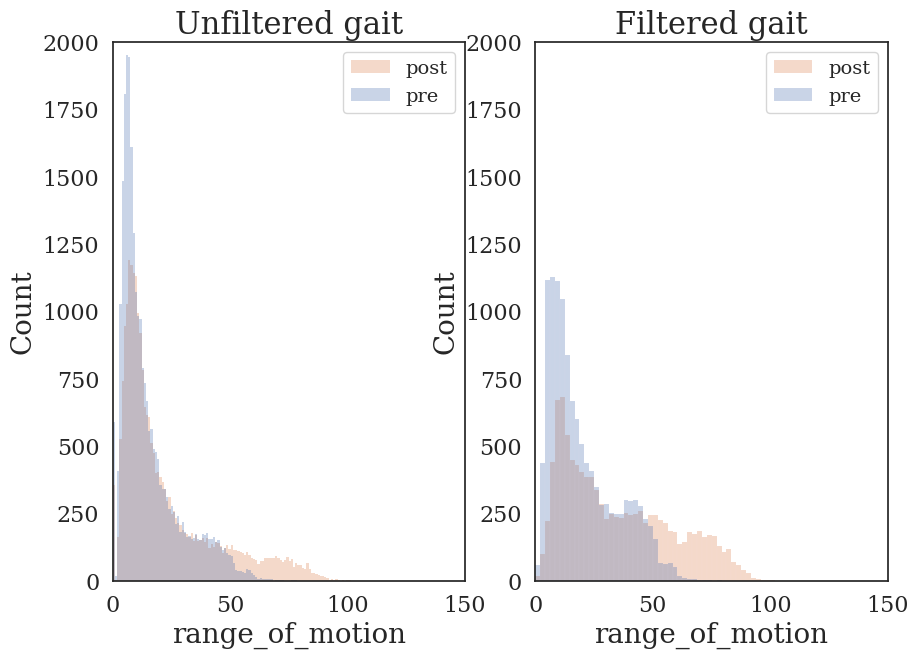

In [28]:
l_dfs = []
for subject in gc.participant_ids.L_PD_IDS:
    l_dfs.append(pd.read_pickle(os.path.join(gc.paths.PATH_ARM_ACTIVITY_FEATURES, f'{subject}_MAS.pkl')))

df_features = pd.concat(l_dfs, ignore_index=True)

fig, ax = plt.subplots(ncols=2, figsize=(10,7))

sns.histplot(data=df_features, x='range_of_motion', hue='pre_or_post', alpha=0.3, color='blue', label='gait', ax=ax[0])
sns.histplot(data=df_features.loc[(df_features['no_other_arm_activity_majority_voting']==1)], x='range_of_motion', hue='pre_or_post', alpha=0.3, color='green', label='gait NOAA', ax=ax[1])

ax[0].set_title('Unfiltered gait')
ax[1].set_title('Filtered gait')

for j in range(2):
    ax[j].set_xlim([0,150])
    ax[j].set_ylim([0, 2000])
    ax[j].legend(['post', 'pre'])

plt.show()

In [29]:
df_features['range_of_motion'].agg(['median', 'mean', 'std'])

median    12.250773
mean      19.037797
std       19.023848
Name: range_of_motion, dtype: float64

In [30]:
df_features.loc[(df_features['no_other_arm_activity_majority_voting']==1), 'range_of_motion'].agg(['median', 'mean', 'std'])

median    20.697746
mean      27.430601
std       23.347205
Name: range_of_motion, dtype: float64

#### 2a - Effect size filtered vs unfiltered gait


Measure: median_rom
P-value overall segments: 0.15364646911621094
P-value short segments: nan
P-value moderately_long segments: 0.3954620361328125
P-value long segments: 0.28372955322265625
P-value very_long segments: 0.8595733642578125

Measure: 95p_rom
P-value overall segments: 1.0
P-value short segments: nan
P-value moderately_long segments: 0.12318801879882812
P-value long segments: 0.39273834228515625
P-value very_long segments: 0.8287849426269531


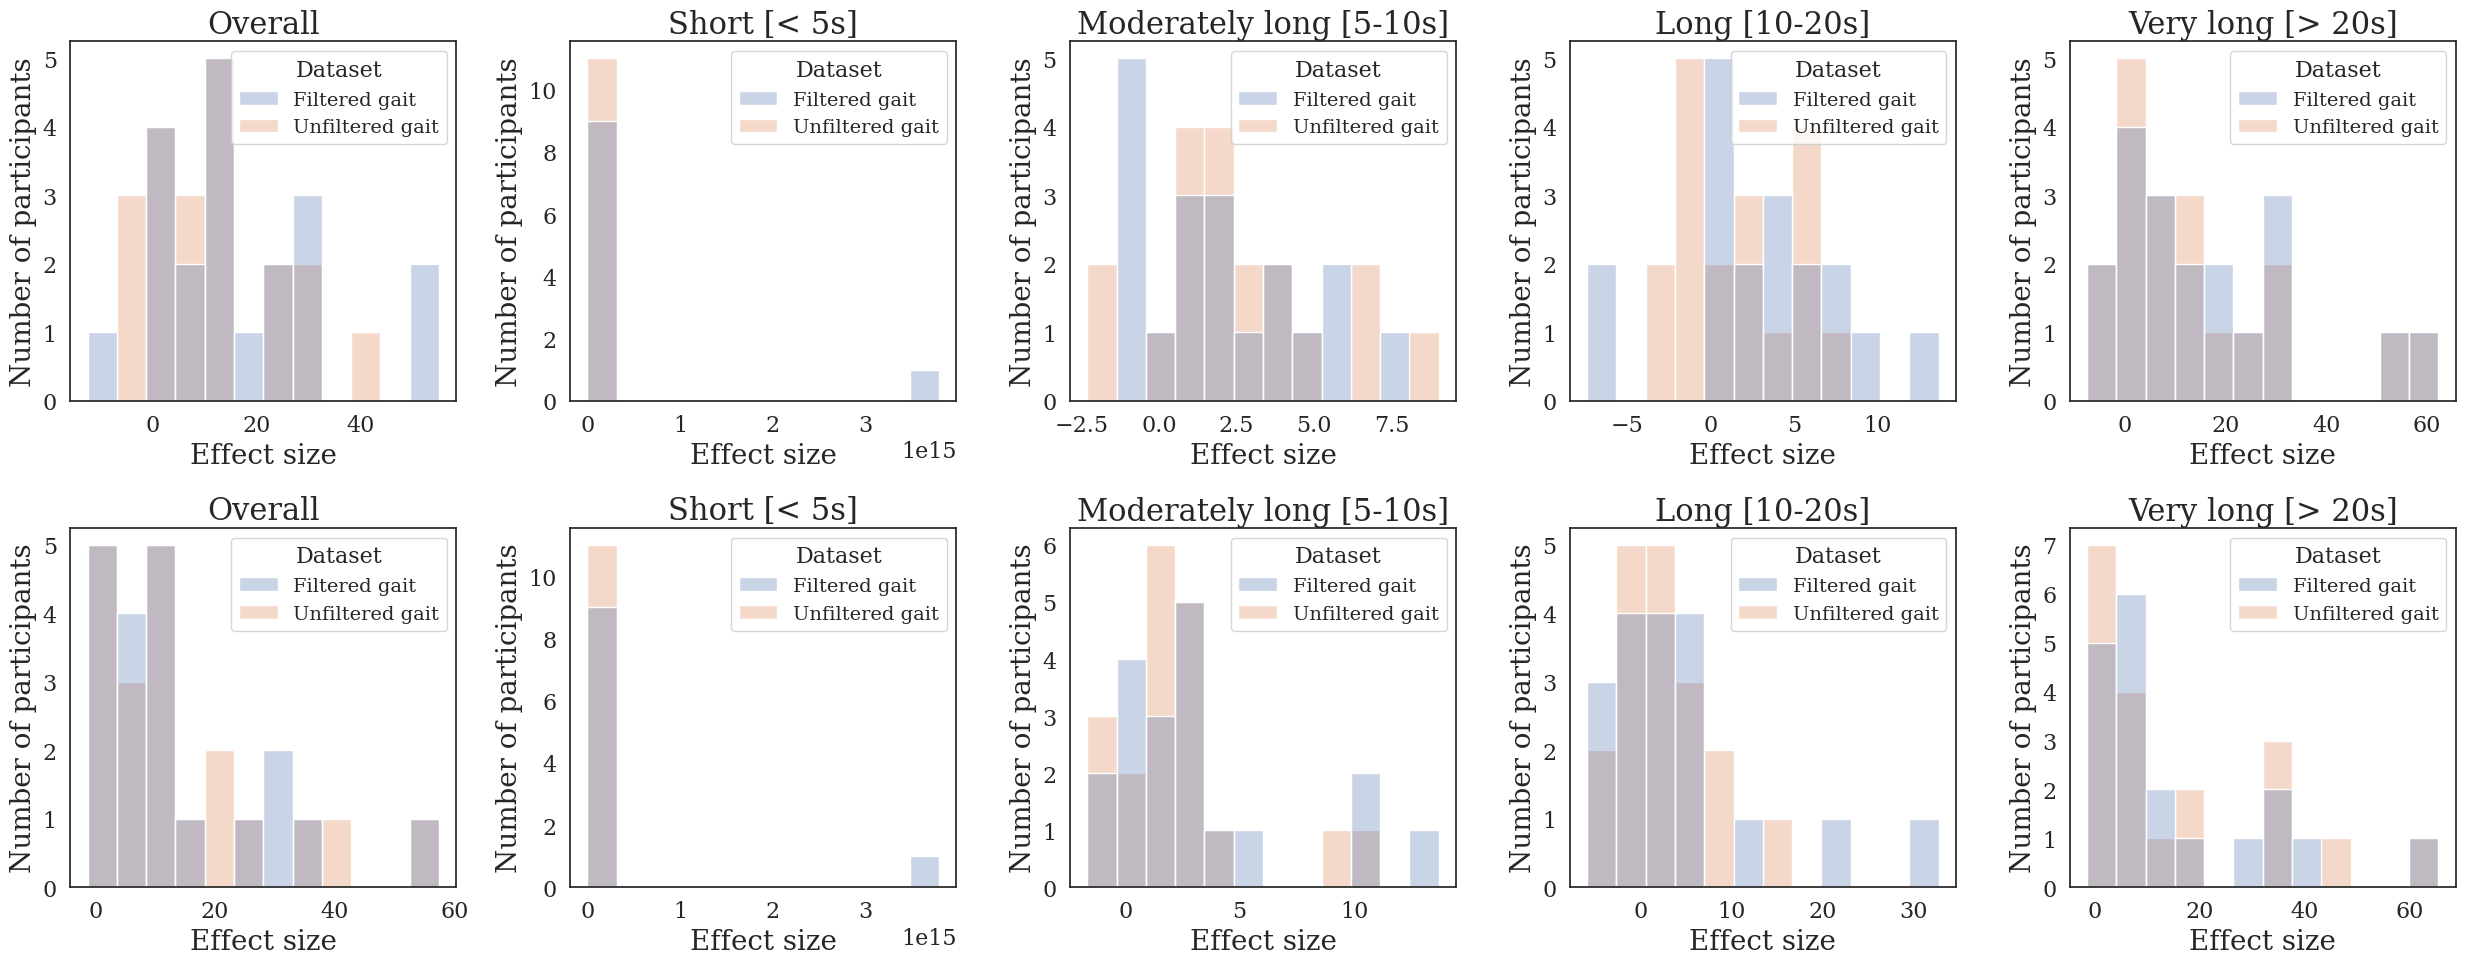

In [31]:
measure = '95p_rom'
segment_duration = 'overall'

dataset_1 = 'pred_gait_predicted_noaa'
dataset_2 = 'predicted_gait'

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))

for i, measure in enumerate(['median_rom', '95p_rom']):
    print(f"\nMeasure: {measure}")
    for j, segment_duration in enumerate(['overall', 'short', 'moderately_long', 'long', 'very_long']):
        l_valid_ids = [x for x in l_valid_pd_ids if segment_duration in d_quant[x]['effect_size'][measure][dataset_1].keys() and segment_duration in d_quant[x]['effect_size'][measure][dataset_2].keys()] 

        l_vals_filtered = [d_quant[x]['effect_size'][measure][dataset_1][segment_duration]['effect_size'] for x in l_valid_ids]
        l_vals_unfiltered = [d_quant[x]['effect_size'][measure][dataset_2][segment_duration]['effect_size'] for x in l_valid_ids]

        df_filtered_gait = pd.DataFrame(l_vals_filtered, columns=['effect_size'])
        df_unfiltered_gait = pd.DataFrame(l_vals_unfiltered, columns=['effect_size'])

        df_filtered_gait['Dataset'] = 'Filtered gait'
        df_unfiltered_gait['Dataset'] = 'Unfiltered gait'

        df_all = pd.concat([df_filtered_gait, df_unfiltered_gait], ignore_index=True).reset_index(drop=True)

        print(f"P-value {segment_duration} segments: {wilcoxon(l_vals_filtered, l_vals_unfiltered, alternative='two-sided')[1]}")

        g = sns.histplot(data=df_all, x='effect_size', hue='Dataset', alpha=0.3, fill=True, bins=12, common_norm=False, legend=False, ax=ax[i,j])

        if segment_duration != 'overall': 
            ax[i,j].set_title(f"{mp.segment_rename[segment_duration]}")
        else:
            ax[i,j].set_title(f"Overall")
        ax[i,j].set_xlabel('Effect size')
        ax[i,j].set_ylabel('Number of participants')
        ax[i,j].yaxis.get_major_locator().set_params(integer=True)
        ax[i,j].legend(title='Dataset', labels=['Unfiltered gait', 'Filtered gait'], reverse=True, loc='upper right')

fig.tight_layout()

plt.show()

#### 2b - Absolute change in arm swing parameters

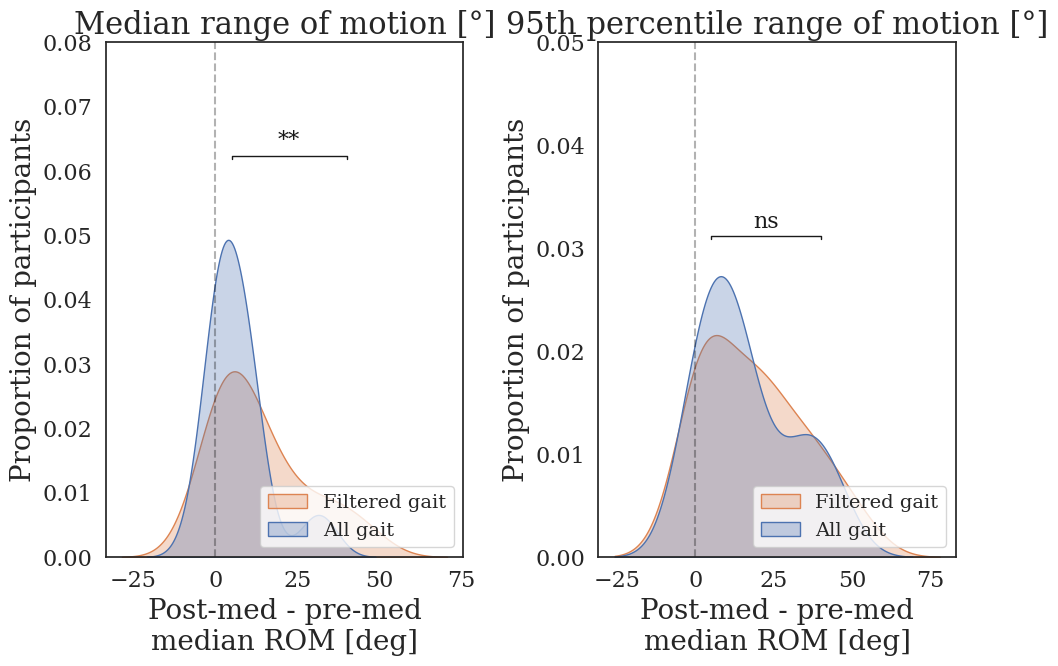

In [32]:
df_abs_change = pd.DataFrame()
for subject in gc.participant_ids.L_PD_IDS:
    for dataset in ['unfiltered_gait', 'filtered_gait']:
        for affected_side in [gc.descriptives.MOST_AFFECTED_SIDE, gc.descriptives.LEAST_AFFECTED_SIDE]:
            for measure in ['range_of_motion_median', 'range_of_motion_quantile_95']:
                if measure in d_quant[subject][dataset]['pre'][affected_side]['values'].keys():
                    abs_change = d_quant[subject][dataset]['post'][affected_side]['values'][measure]['overall'] - d_quant[subject][dataset]['pre'][affected_side]['values'][measure]['overall']
                    df_abs_change = pd.concat([df_abs_change, pd.DataFrame([subject, dataset, affected_side, measure, abs_change], index=['id', 'dataset', 'side', 'measure', 'abs_change']).T])

fig, ax = plt.subplots(ncols=2, figsize=(10,7))

for j, measure in enumerate(['range_of_motion_median', 'range_of_motion_quantile_95']):

    df_measure = df_abs_change.loc[(df_abs_change['measure']==measure) & (df_abs_change['side']=='MAS')]

    sns.kdeplot(data=df_measure, x='abs_change', hue='dataset', alpha=0.3, fill=True, common_norm=False, ax=ax[j])

    # ax.set_xlim([df_abs_change[f'{metric}_diff'].min(), df_abs_change[f'{metric}_diff'].max()])

    p_value = calculate_pvalue(x=list(df_measure.loc[df_measure['dataset']=='unfiltered_gait', 'abs_change'].values), 
                               y=list(df_measure.loc[df_measure['dataset']=='filtered_gait', 'abs_change'].values),
                               test='wilcoxon')[1]

    x_min = 5
    x_max = 40
    if j == 0:
        y_min_significance = 0.06
        y_max = 0.08
    else:
        y_min_significance = 0.03
        y_max = 0.05

    plot_significance(ax=ax[j], x_min=x_min, x_max=x_max, pvalue=p_value, y_min_significance=y_min_significance, gap=0, row=1, text_size=16)
    ax[j].set_ylim([0, y_max])
    ax[j].axvline(0, color='black', linestyle='--', alpha=0.3)

    # xlabel =  'Post-med - pre-med\n' + r'$95^{th}$ perc ROM [deg]'
    xlabel = 'Post-med - pre-med\nmedian ROM [deg]'

    ax[j].set_title(mp.arm_swing_parameter_map[measure])
    ax[j].legend(['Filtered gait', 'All gait'], loc='lower right')
    ax[j].set_xlabel(xlabel)
    ax[j].set_ylabel('Proportion of participants')
# plt.ylim([0, 0.18])
# plt.title("Difference in median range of motion between PD OFF and PD ON")

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_diff_density_med.png'))

plt.show()

In [33]:
# Standard deviation
df_std = pd.DataFrame()
for subject in gc.participant_ids.L_PD_IDS:
    for dataset in ['predicted_gait', 'pred_gait_annotated_noaa', 'pred_gait_predicted_noaa']:
        for measure in ['median_rom', '95p_rom']:
            for stat in ['mu_pre', 'mu_post', 'std', 'effect_size']:
                df_std = pd.concat([df_std, pd.DataFrame([subject, dataset, measure, stat, d_quant[subject]['effect_size'][measure][dataset]['overall'][stat]], index=['id', 'dataset', 'measure', 'stat', 'value']).T])
            
df_std.pivot_table(index='dataset', columns=['measure', 'stat'], values='value').reindex(['median_rom', '95p_rom'], axis=1, level=0).sort_index(ascending=False)

measure                   median_rom                                  \
stat                     effect_size    mu_post     mu_pre       std   
dataset                                                                
predicted_gait             11.194371  20.388634  13.564605  0.729861   
pred_gait_predicted_noaa   15.168002  29.627981  16.092715  0.987817   
pred_gait_annotated_noaa   17.577443  31.080913  15.853796  1.038464   

measure                      95p_rom                                  
stat                     effect_size    mu_post     mu_pre       std  
dataset                                                               
predicted_gait              13.77081  45.629559  29.358658  1.534175  
pred_gait_predicted_noaa   12.806175  47.651235   29.27275   2.46026  
pred_gait_annotated_noaa   12.511019  47.762885  29.577775  2.397975

#### 2c - Change in ROM distribution

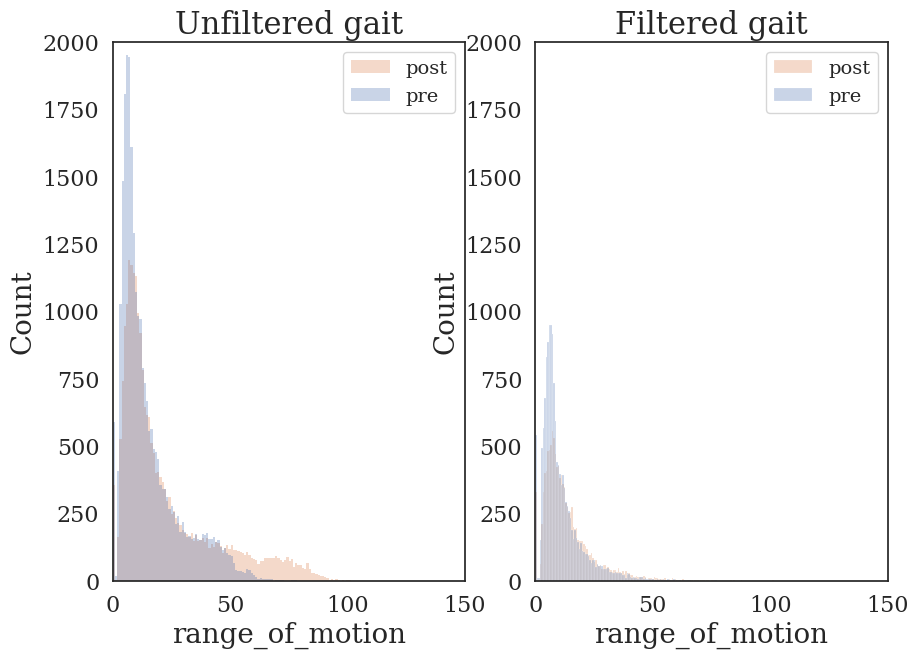

In [34]:
l_dfs = []
for subject in gc.participant_ids.L_PD_IDS:
    df_features = pd.read_pickle(os.path.join(gc.paths.PATH_ARM_ACTIVITY_FEATURES, f'{subject}_MAS.pkl'))
    df_features[gc.columns.ID] = subject
    df_predictions = pd.read_pickle(os.path.join(gc.paths.PATH_ARM_ACTIVITY_PREDICTIONS, gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED, f'{subject}_df.pkl'))
    df_predictions = df_predictions.loc[df_predictions['side']=='MAS', ['window_nr', gc.columns.PRED_NO_OTHER_ARM_ACTIVITY_PROBA]]

    l_dfs.append(pd.merge(df_features, df_predictions, on='window_nr', how='inner'))

df_features = pd.concat(l_dfs, ignore_index=True)

fig, ax = plt.subplots(ncols=2, figsize=(10,7))

sns.histplot(data=df_features, x='range_of_motion', hue='pre_or_post', alpha=0.3, color='blue', ax=ax[0])
sns.histplot(data=df_features.loc[(df_features[gc.columns.PRED_NO_OTHER_ARM_ACTIVITY_PROBA]<0.5)], x='range_of_motion', hue='pre_or_post', alpha=0.3, color='green', ax=ax[1])

ax[0].set_title('Unfiltered gait')
ax[1].set_title('Filtered gait')

for j in range(2):
    ax[j].set_xlim([0,150])
    ax[j].legend(['post', 'pre'])
    ax[j].set_ylim([0, 2000])

plt.show()